In [1]:
%run cv.ipynb

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
train_texts_features = pd.read_pickle(output_path + '/train_text_features9')
test_texts_features = pd.read_pickle(output_path + '/test_text_features9')

In [3]:
train_texts_features['positivity'] = pd.read_pickle(output_path + '/positivity_train2').positivity
test_texts_features['positivity'] = pd.read_pickle(output_path + '/positivity_test2').positivity

In [4]:
train_texts_features.drop('embedding', 1, inplace=True)
test_texts_features.drop('embedding', 1, inplace=True)
#train_texts_features['embedding_lgb'] = pd.read_pickle(output_path + '/train_30_2_svd').embeddings
#test_texts_features['embedding_lgb'] = pd.read_pickle(output_path + '/test_30_2_svd').embeddings
train_texts_features['embedding_keras'] = pd.read_pickle(output_path + '/train__80__svd').embeddings
test_texts_features['embedding_keras'] = pd.read_pickle(output_path + '/test__80__svd').embeddings

#train_80_1_svd

In [101]:
train_texts_features['embedding'] = pd.read_pickle(output_path + '/train_100_embs').embeddings
test_texts_features['embedding'] = pd.read_pickle(output_path + '/test_100_embs').embeddings

In [5]:
assigned_clusters3_15 = pd.read_pickle(output_path + '/assigned_clusters3_15').assigned_clusters3_15
train_texts_features['assigned_clusters'] = assigned_clusters3_15[0:train_texts_features.shape[0]]

In [6]:
train_data = pd.read_pickle(output_path + '/train_data')
test_data = pd.read_pickle(output_path + '/test_data')

In [7]:
stat = pd.concat((train_data, test_data), sort=False)[['metadata_ownerId', 'objectId']] \
    .groupby('metadata_ownerId').agg({'objectId': 'count'})
stat.rename(columns={'objectId': 'owner_count'}, inplace=True)

In [8]:
stat3 = pd.concat((train_data, test_data), sort=False)[['objectId', 'instanceId_userId']] \
    .groupby('instanceId_userId').agg({'objectId': 'count'})
stat3.rename(columns={'objectId': 'user_count'}, inplace=True)

In [9]:
#stat2 = pd.concat((train_data, test_data), sort=False)[['objectId', 'instanceId_userId']] \
#    .groupby('objectId').agg({'instanceId_userId': 'count'})
#stat2.rename(columns={'instanceId_userId': 'object_count'}, inplace=True)

In [10]:
train_data = train_data.join(stat, how='left', on='metadata_ownerId')
#train_data = train_data.join(stat2, how='left', on='metadata_ownerId')
train_data = train_data.join(stat3, how='left', on='instanceId_userId')
train_data = train_data.join(train_texts_features.set_index('objectId'), how='inner', on='objectId')

In [11]:
test_data = test_data.join(stat, how='left', on='metadata_ownerId')
#test_data = test_data.join(stat2, how='left', on='metadata_ownerId')
test_data = test_data.join(stat3, how='left', on='instanceId_userId')
test_data = test_data.join(test_texts_features.set_index('objectId'), how='inner', on='objectId')

In [12]:
qq = train_data[['instanceId_userId', 'objectId', 'audit_timestamp']].groupby(['instanceId_userId', 'objectId']).count()
qq.rename(columns={'audit_timestamp': 'edits_count'}, inplace=True)
train_data = train_data.join(qq, how='left', on=['instanceId_userId', 'objectId'])


In [13]:
qq = test_data[['instanceId_userId', 'objectId', 'audit_timestamp']].groupby(['instanceId_userId', 'objectId']).count()
qq.rename(columns={'audit_timestamp': 'edits_count'}, inplace=True)
test_data = test_data.join(qq, how='left', on=['instanceId_userId', 'objectId'])



In [14]:
class LgbModel(MyModel):
    def get_X(self, data):
        X = super().get_X(data)
        ###!!!!!!
        X.drop([c for c in X.columns if c.startswith('embedding') and not c.startswith('embedding_keras')], 1, inplace=True)
        X.drop(['end', 'is_ru'], 1, inplace=True)
        return X
    def fit(self, data):
        #data = data.drop_duplicates(['instanceId_userId', 'objectId'], keep='last')
        
        #owner_stat = data[['metadata_ownerId', 'label']].groupby('metadata_ownerId').mean()
        #owner_stat.rename(columns={'label': 'owner_mean_label'}, inplace=True)
        #self.owner_stat = owner_stat
        #data = data.join(owner_stat, how='left', on='metadata_ownerId')
        '''
        grp = data[['instanceId_userId', 'label']].groupby('instanceId_userId')
        self.owner_stat = grp.sum() / (grp.count() + 1)
        self.owner_stat.rename(columns={'label': 'owner_mean_label'}, inplace=True)

        owner_sum_stat = grp.sum()
        owner_cnt_stat = grp.count()
        owner_sum_stat.rename(columns={'label': 'owner_sum_label'}, inplace=True)
        owner_cnt_stat.rename(columns={'label': 'owner_cnt_label'}, inplace=True)

        data = data.join(owner_sum_stat, how='left', on='instanceId_userId')
        data = data.join(owner_cnt_stat, how='left', on='instanceId_userId')
        data['owner_mean_label'] = (data['owner_sum_label'] - data['label']) / data['owner_cnt_label']
        data.drop(['owner_sum_label', 'owner_cnt_label'], 1, inplace=True)
        '''
        y = data['label']
        lgb_train = lgb.Dataset(self.get_X(data), y)
        categorical_feature=['assigned_clusters']
        
        #if self.verbose >= 2:
        print('Starting train: %s' % datetime.datetime.now())
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        #params['objective'] = 'binary'
        params['metric'] = 'auc'
        self.model = lgb.train(
            params,
            lgb_train,
            num_boost_round=num_boost_round
        )
    def predict(self, data):
        #data = data.join(self.owner_stat, how='left', on='metadata_ownerId')
        #data = data.join(self.owner_stat, how='left', on='instanceId_userId')
        proba = self.model.predict(self.get_X(data))
        return proba

class KerasModel(MyModel):
    def get_X(self, data):
        X = super().get_X(data)
        X.drop([c for c in X.columns if c.startswith('embedding') and not c.startswith(self.params['emb'])], 1, inplace=True)
        X.drop(['end', 'is_ru'], 1, inplace=True)
        return X
    def fit(self, data):
        params = self.params
        self.scaler = MyScaler()
        X = self.get_X(data)
        self.scaler.fit_transform(X, inplace=True)
        y = data['label'].values
        
        model = keras.models.Sequential()
        self.model = model

        model.add(keras.layers.Dense(params['n1'], activation = "relu", input_shape=(X.shape[1], )))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU())

        model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
        model.add(keras.layers.Dense(params['n2'], activation = "relu"))
        model.add(keras.layers.BatchNormalization())
        
        if 'n3' in params:
            model.add(keras.layers.Dropout(params['dropout'], noise_shape=None, seed=1))
            model.add(keras.layers.Dense(params['n3'], activation = "relu"))
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(1, activation = "sigmoid"))
        model.summary()
        model.compile(
            optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
            loss = "binary_crossentropy",
            metrics = ["accuracy"]
        )
        results = model.fit(
            X, y,
            epochs=params['epochs'],
            batch_size=params.get('batch_size', 1024),
            verbose=params['verbose']
        )

    def predict(self, X):
        X = self.get_X(X)
        self.scaler.transform(X, inplace=True)
        return self.model.predict(X)[:,0]


In [15]:
def feat(x):
    n = x.shape[0]
    return np.add.reduce(x.embedding.values) / n

class MyScaler():
    def fit_transform(self, X, inplace=False):
        assert inplace

        self.columns = []
        for c in X.columns:
            if c != 'label':
                self.columns.append(c)
        
        self.means = []
        self.sds = []
        self.mins = []
        self.maxs = []
        for c in self.columns:
            self.means.append(np.mean(X[c]))
            self.sds.append(np.std(X[c]))
            self.mins.append(np.min(X[c]))
            self.maxs.append(np.max(X[c]))
        return self.transform(X, inplace=inplace)
    
    def transform(self, X, inplace=False):
        assert inplace
        for c, mean, sd, mn, mx in zip(self.columns, self.means, self.sds, self.mins, self.maxs):
            X[c] = ((X[c] - mean) / sd).astype(np.float32)
            #X[c] = ((X[c].astype(np.float64) - float(mn)) / (float(mx) - float(mn))).astype(np.float32)
        
def create_features(data):
    ones = np.repeat(1, data.shape[0])
    res = pd.DataFrame({
        'instanceId_userId': data['instanceId_userId'],
        'objectId': data['objectId'],
        'object_type': data['instanceId_objectType'],
        'client_type': data['audit_clientType'],
#        'object_type_0': data['instanceId_objectType'] == 0,
#        'object_type_1': data['instanceId_objectType'] == 1,
#        'object_type_2': data['instanceId_objectType'] == 2,
#        'client_type_0': data['audit_clientType'] == 0,
#        'client_type_1': data['audit_clientType'] == 1,
#        'client_type_2': data['audit_clientType'] == 2,
        
        #'is_longread': data['len'] > 400,
        #'len': data['len'],
        #'p_len': data['p_len'],
        'len_log': np.log(data['len'] + 1).astype(np.float32),
        'p_len_log': np.log(data['p_len'] + 1).astype(np.float32),
        #'plen_per_len': data['p_len'] / data['len'],
        'q_count': np.log(data['q_count'] + 1).astype(np.float32),
        'links_count': np.log(data['links_count'] + 1).astype(np.float32),
        'emojis_rate': (data['emojis_count'] / data['len']).astype(np.float32),
        'upper_rate': (data['upper_count'] / data['len']).astype(np.float32),
        #'upper_count': data['upper_count'],
        'ok_videos_count': data['ok_videos_count'].clip(upper=1).astype(np.int8),
        'ok_groups_count': data['ok_groups_count'].clip(upper=1).astype(np.int8),
        'youtube_count': data['youtube_count'].clip(upper=1).astype(np.int8),
        #'is_video': (data['youtube_count'] + data['ok_videos_count']).clip(upper=1),
        'is_adv': data['is_adv'].astype(np.int8),
        'is_recipe': data['is_recipe'].astype(np.int8),
  #      'brackets_balance': data['brackets_balance'],
        'brackets_balance_log': np.log(data['brackets_balance'].abs() + 1).astype(np.float32),
        'quotes_count': np.log(data['quotes_count'] + 1).astype(np.float32),
        'mdots_count': np.log(data['mdots_count'] + 1).astype(np.float32),
        'e_count': np.log(data['e_count'] + 1).astype(np.float32),
        #'assigned_clusters': data['assigned_clusters'],
        'owner_count': data['owner_count'],
        'old': data['audit_timestamp'] - data['metadata_createdAt'],
        #'wtf': data['audit_timestamp'] <= data['metadata_createdAt'],
        #'mean_target': data['mean_target'],
        'has_phone': data['has_phone'].astype(np.int8),                                     #sm+
        'hashes_count': np.log(data['hashes_count'] + 1).astype(np.float32),#---
        'is_ru': data['lang'] == 'ru',#---
        ###'is_day': data['is_day'],#---
        'has_newline': data['lines_count'].clip(upper=1).astype(np.int8),                   #sm+
        #'object_count': data['object_count'],
        'user_count': data['user_count'],
        'end': data['e_end'] | data['q_end'] | data['d_end'],#---
        ####'md_count': data['md_count'].clip(upper=1),#---
        #'positivity': data['positivity'].fillna(0.5).astype(np.float32),
        'metadata_ownerId': data['metadata_ownerId'],
        #'unliked': data['unliked'],
        #'audit_timestamp_day': data['audit_timestamp'] % (3600*24),
        #'edits_count': data['edits_count'].clip(upper=2).astype(np.int8),
        'edits_count': np.log(data['edits_count'] + 1).astype(np.float32),
    })
    #qq = data[['instanceId_userId', 'embedding']].join(
    #        data.groupby('instanceId_userId').apply(feat).reset_index().set_index('instanceId_userId'), 
    #        on='instanceId_userId')
    #print('Cosing:')
    #res['emb_dist'] = (qq.iloc[:,1] - qq.iloc[:,2]).apply(np.linalg.norm)
    #res['emb_cosine_dist'] = qq.iloc[:,1:3].apply(lambda x: scipy.spatial.distance.cosine(*x), axis=1)
    #print('Embs:')
    
    #for e in ('embedding_lgb', 'embedding_keras', 'embedding'):
    for e in ('embedding_keras',):
    #for e in ('embedding',):
        emb = np.stack(data[e])
        for j in range(emb.shape[1]):
            res['%s_%d' % (e, j)] = emb[:,j].astype(np.float32)

    if 'liked' in data.columns:
        res['label'] = data['liked']
    for c in ('clicked', 'viewed', 'disliked', 'reshared', 'ignored', 'commented', 'complaint', 'unliked'):
        if c in data.columns:
            res[c] = data[c]
            
    return res

In [16]:
%%time
ttt = create_features(train_data.head(10000))

CPU times: user 94.7 ms, sys: 95.7 ms, total: 190 ms
Wall time: 352 ms


In [17]:
%%time
train = create_features(train_data)

CPU times: user 1min 18s, sys: 46.5 s, total: 2min 4s
Wall time: 2min 34s


In [18]:
#train[['objectId', 'hashes_count']].groupby('hashes_count').count()

In [19]:
plt.figure(figsize=(20,10))
plt.hist(train.edits_count, 100, color='red', alpha=0.5, stacked=True)
plt.show()

NameError: name 'train' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(np.log(train.edits_count + 1), 100, color='red', alpha=0.5, stacked=True)
plt.show()

In [ ]:
sub = train[train.instanceId_userId % 4 == 1]

In [48]:
sub = create_features(train_data[train_data.instanceId_userId % 4 == 1])

In [49]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5]), sub, n_iters=1, verbose=2)


KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-15 13:36:20.121715
Fit: 2019-03-15 13:36:30.404223
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 170)               17850     
_________________________________________________________________
batch_normalization_1 (Batch (None, 170)               680       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_2 (Dense)              

KeyboardInterrupt: 

In [127]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5]), sub, n_iters=1, verbose=2)


KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-15 01:17:09.277304
Fit: 2019-03-15 01:17:13.850541
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 170)               17850     
_________________________________________________________________
batch_normalization_33 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_34 (Batc (None, 170)               680       
__________________

Epoch 1/10
 - 63s - loss: 0.4050 - acc: 0.8456
Epoch 2/10
 - 61s - loss: 0.3965 - acc: 0.8478
Epoch 3/10
 - 61s - loss: 0.3948 - acc: 0.8479
Epoch 4/10
 - 61s - loss: 0.3938 - acc: 0.8479
Epoch 5/10
 - 61s - loss: 0.3930 - acc: 0.8479
Epoch 6/10
 - 62s - loss: 0.3922 - acc: 0.8479
Epoch 7/10
 - 60s - loss: 0.3915 - acc: 0.8479
Epoch 8/10
 - 60s - loss: 0.3910 - acc: 0.8479
Epoch 9/10
 - 61s - loss: 0.3904 - acc: 0.8479
Epoch 10/10
 - 62s - loss: 0.3901 - acc: 0.8480
Starting train: 2019-03-15 02:38:44.854865
Predict: 2019-03-15 02:44:35.049848
Auc: 2019-03-15 02:45:26.789399
 0 - 5 : 0.6588, mean=0.6584
CPU times: user 4h 35min 34s, sys: 23min 15s, total: 4h 58min 50s
Wall time: 1h 28min 18s


In [125]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5]), sub, n_iters=1, verbose=2)


KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-15 00:53:40.974768
Fit: 2019-03-15 00:53:53.177971
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 170)               18190     
_________________________________________________________________
batch_normalization_31 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_32 (Batc (None, 170)               680       
__________________

KeyboardInterrupt: 

In [42]:
%%time
seed_everything(341)
cross_validation(KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-14 17:25:34.794455
Fit: 2019-03-14 17:26:27.317152
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 170)               18190     
_________________________________________________________________
batch_normalization_3 (Batch (None, 170)               680       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 170)               29070     
_________________________________________________________________
batch_normalization_4 (Batch (None, 170)               680       
__________________

Epoch 1/10
 - 59s - loss: 0.4048 - acc: 0.8457
Epoch 2/10
 - 57s - loss: 0.3963 - acc: 0.8479
Epoch 3/10
 - 58s - loss: 0.3947 - acc: 0.8479
Epoch 4/10
 - 56s - loss: 0.3937 - acc: 0.8479
Epoch 5/10
 - 62s - loss: 0.3929 - acc: 0.8479
Epoch 6/10
 - 65s - loss: 0.3922 - acc: 0.8479
Epoch 7/10
 - 65s - loss: 0.3917 - acc: 0.8479
Epoch 8/10
 - 63s - loss: 0.3911 - acc: 0.8479
Epoch 9/10
 - 64s - loss: 0.3905 - acc: 0.8480
Epoch 10/10
 - 63s - loss: 0.3901 - acc: 0.8480
Predict: 2019-03-14 18:22:48.522196
Auc: 2019-03-14 18:23:14.214882
 0 - 5 : 0.6536, mean=0.6524
CPU times: user 2h 33min 2s, sys: 23min 27s, total: 2h 56min 29s
Wall time: 57min 40s


In [43]:
%%time
seed_everything(341)
cross_validation(KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'n3': 85,
    'dropout': 0.15,
    'emb': 'embedding_keras',
}), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-14 18:23:14.835496
Fit: 2019-03-14 18:23:40.606073
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 170)               18190     
_________________________________________________________________
batch_normalization_13 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_14 (Batc (None, 170)               680       
__________________

KeyboardInterrupt: 

In [42]:
%%time
seed_everything(341)
cross_validation(KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'n3': 85,
    'dropout': 0.15,
    'emb': 'embedding',
}), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-13 23:46:59.745711
Fit: 2019-03-13 23:47:08.745157
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 170)               21590     
_________________________________________________________________
batch_normalization_24 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_25 (Batc (None, 170)               680       
__________________

KeyboardInterrupt: 

In [35]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'n3': 85,
    'dropout': 0.15,
    'emb': 'embedding',
}), KerasModel({
    'epochs': 10,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.3, 0.5, 0.5]), sub, n_iters=1, verbose=2)


KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-14 01:59:21.192266
Fit: 2019-03-14 01:59:53.588089
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 170)               40290     
_________________________________________________________________
batch_normalization_14 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_15 (Batc (None, 170)               680       
__________________

Prepare data: 2019-03-14 03:23:59.636542
Fit: 2019-03-14 03:24:23.414990
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 170)               40290     
_________________________________________________________________
batch_normalization_24 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_25 (Batc (None, 170)               680       
_________________________________________________________________
dro

Fit: 2019-03-14 04:47:44.311251
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 170)               40290     
_________________________________________________________________
batch_normalization_34 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_35 (Batc (None, 170)               680       
_________________________________________________________________
dropout_22 (Dropout)         (None, 170)    

In [83]:
%%time
#################################### new
for min_data_in_leaf in (25,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), sub, n_iters=1, verbose=2, split_by='objectId')


(25, 0.0, 0.35, 1, 1000, 30)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-13 13:30:11.582781
Fit: 2019-03-13 13:30:28.158089
Starting train: 2019-03-13 13:30:34.775824
Predict: 2019-03-13 13:39:14.415133
Auc: 2019-03-13 13:39:54.823917
 0 - 1 : 0.6394, mean=0.6394
Prepare data: 2019-03-13 13:39:55.225376
Fit: 2019-03-13 13:40:21.320190
Starting train: 2019-03-13 13:40:32.937569
Predict: 2019-03-13 13:49:35.452707
Auc: 2019-03-13 13:50:08.747280
 0 - 2 : 0.6399, mean=0.6396
Prepare data: 2019-03-13 13:50:09.102442
Fit: 2019-03-13 13:50:27.241335
Starting train: 2019-03-13 13:50:34.803271
Predict: 2019-03-13 13:59:36.005910
Auc: 2019-03-13 14:00:10.849836
 0 - 3 : 0.6383, mean=0.6392
Prepare data: 2019-03-13 14:00:11.209648
Fit: 2019-03-13 14:00:27.990000
Starting train: 2019-03-13 14:00:35.559242
Predict: 2019-03-13 14:09:26.295078
Auc: 2019-03-13 14:09:53.007898
 0 - 4 : 0.6360, mean=0.6384
Prepare data: 2019-03-13 14:09:53.339077
Fit: 2019-03-13 14:10:15.13

In [27]:
%%time
#################################### старая версия
for min_data_in_leaf in (25,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), sub, n_iters=1, verbose=2, split_by='objectId')


(25, 0.0, 0.35, 1, 1000, 30)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-13 11:04:15.825459
Fit: 2019-03-13 11:04:27.095029
Starting train: 2019-03-13 11:04:34.196130
Predict: 2019-03-13 11:08:46.388544
Auc: 2019-03-13 11:09:08.600697
 0 - 1 : 0.6410, mean=0.6410
Prepare data: 2019-03-13 11:09:09.021813
Fit: 2019-03-13 11:09:24.230877
Starting train: 2019-03-13 11:09:27.807317
Predict: 2019-03-13 11:13:32.271267
Auc: 2019-03-13 11:13:50.741636
 0 - 2 : 0.6365, mean=0.6388
Prepare data: 2019-03-13 11:13:51.044617
Fit: 2019-03-13 11:14:05.955971
Starting train: 2019-03-13 11:14:13.692660
Predict: 2019-03-13 11:18:26.937961
Auc: 2019-03-13 11:18:47.643365
 0 - 3 : 0.6366, mean=0.6381
Prepare data: 2019-03-13 11:18:47.984787
Fit: 2019-03-13 11:19:12.793454
Starting train: 2019-03-13 11:19:22.310795
Predict: 2019-03-13 11:23:50.365574
Auc: 2019-03-13 11:24:10.249879
 0 - 4 : 0.6357, mean=0.6375
Prepare data: 2019-03-13 11:24:10.550065
Fit: 2019-03-13 11:24:28.05

In [59]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5]), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-11 01:03:47.840738
Fit: 2019-03-11 01:03:55.981848
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 170)               17850     
_________________________________________________________________
batch_normalization_15 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_16 (Batc (None, 170)               680       
__________________

Epoch 1/10
 - 66s - loss: 0.4074 - acc: 0.8456
Epoch 2/10
 - 60s - loss: 0.3990 - acc: 0.8478
Epoch 3/10
 - 59s - loss: 0.3973 - acc: 0.8479
Epoch 4/10
 - 59s - loss: 0.3964 - acc: 0.8479
Epoch 5/10
 - 60s - loss: 0.3956 - acc: 0.8479
Epoch 6/10
 - 59s - loss: 0.3949 - acc: 0.8479
Epoch 7/10
 - 58s - loss: 0.3944 - acc: 0.8479
Epoch 8/10
 - 58s - loss: 0.3939 - acc: 0.8479
Epoch 9/10
 - 59s - loss: 0.3935 - acc: 0.8479
Epoch 10/10
 - 60s - loss: 0.3931 - acc: 0.8479
Starting train: 2019-03-11 02:15:50.197920
Predict: 2019-03-11 02:19:41.508979
Auc: 2019-03-11 02:20:31.741966
 0 - 5 : 0.6561, mean=0.6551
CPU times: user 3h 47min 49s, sys: 23min 49s, total: 4h 11min 39s
Wall time: 1h 16min 44s


In [ ]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5]), train, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-11 05:49:57.609789
Fit: 2019-03-11 05:51:13.283459
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 170)               17850     
_________________________________________________________________
batch_normalization_27 (Batc (None, 170)               680       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 170)               29070     
_________________________________________________________________
batch_normalization_28 (Batc (None, 170)               680       
__________________

In [38]:
%%time
seed_everything(341)
cross_validation(MeanModel([KerasModel({
    'epochs': 10,
    'verbose': 2,
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.4, 0.6]), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-10 12:16:23.137937
Fit: 2019-03-10 12:16:36.255492
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 170)               18020     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 170)               29070     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 171       
Total params: 47,261
Trainable params: 47,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 

KeyboardInterrupt: 

In [115]:
%%time
seed_everything(341)
cross_validation(KerasModel({
    'epochs': 10,
    'verbose': 2,
}), sub, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-09 22:39:09.654425
Fit: 2019-03-09 22:39:16.206803
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 170)               18700     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 170)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 170)               29070     
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 171       
Total params: 47,941
Trainable params: 47,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 

KeyboardInterrupt: 

In [19]:
%%time
#################################### PARTIAL TRAIN
for min_data_in_leaf in (25,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), sub, n_iters=1, verbose=2)

(25, 0.0, 0.35, 1, 1000, 30)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-09 13:01:47.582152
Fit: 2019-03-09 13:01:51.349356
Starting train: 2019-03-09 13:01:53.752369
Predict: 2019-03-09 13:05:47.094824
Auc: 2019-03-09 13:06:03.430540
 0 - 1 : 0.6498, mean=0.6498
Prepare data: 2019-03-09 13:06:03.655497
Fit: 2019-03-09 13:06:10.751042
Starting train: 2019-03-09 13:06:12.187180
Predict: 2019-03-09 13:09:57.993294
Auc: 2019-03-09 13:10:13.762770
 0 - 2 : 0.6485, mean=0.6491
Prepare data: 2019-03-09 13:10:13.994431
Fit: 2019-03-09 13:10:21.106000
Starting train: 2019-03-09 13:10:22.502458
Predict: 2019-03-09 13:14:10.567627
Auc: 2019-03-09 13:14:27.225390
 0 - 3 : 0.6486, mean=0.6490
Prepare data: 2019-03-09 13:14:27.460103
Fit: 2019-03-09 13:14:31.091658
Starting train: 2019-03-09 13:14:32.705446
Predict: 2019-03-09 13:18:35.128126
Auc: 2019-03-09 13:18:51.722594
 0 - 4 : 0.6504, mean=0.6493
Prepare data: 2019-03-09 13:18:51.960068
Fit: 2019-03-09 13:18:56.87

In [24]:
%%time
for min_data_in_leaf in (25,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), train, n_iters=1, verbose=2)

(25, 0.0, 0.35, 1, 1000, 30)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-09 17:02:47.919122
Fit: 2019-03-09 17:03:23.356649
Starting train: 2019-03-09 17:03:43.841102
Predict: 2019-03-09 17:28:47.218106
Auc: 2019-03-09 17:30:27.322895
 0 - 1 : 0.6616, mean=0.6616
Prepare data: 2019-03-09 17:30:28.524928


KeyboardInterrupt: 

In [75]:
del train_texts_features
del test_texts_features
gc.collect()

28

In [ ]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train[train.instanceId_userId % 4 == 0], n_iters=1, verbose=2)
#0 - 1 : 0.6302, mean=0.6302
#0 - 2 : 0.6340, mean=0.6321
#0 - 3 : 0.6336, mean=0.6326
#0 - 4 : 0.6349, mean=0.6332
#0 - 5 : 0.6355, mean=0.6336

In [ ]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train, n_iters=1, verbose=2)
#0 - 1 : 0.6343, mean=0.6343
#0 - 2 : 0.6350, mean=0.6347
#0 - 3 : 0.6336, mean=0.6343
#0 - 4 : 0.6362, mean=0.6348
#0 - 5 : 0.6335, mean=0.6345

In [140]:
cross_validation(MeanModel([SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), LgbModel({
    #'num_threads': 4,
    #'objective': 'binary',
    'boosting_type': 'gbdt',
    'min_data_in_leaf': min_data_in_leaf,
    'lambda_l2': lambda_l2,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': num_boost_round,
    #'max_depth': 4,
    'verbose': 0
})], [0.2, 0.8]), train[train.instanceId_userId % 4 == 0], n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 12:55:49.726751
Fit: 2019-03-03 12:55:53.899066
Starting train: 2019-03-03 13:00:23.640107
Predict: 2019-03-03 13:02:31.636356
Auc: 2019-03-03 13:02:43.630157
 0 - 1 : 0.6428, mean=0.6428
Prepare data: 2019-03-03 13:02:43.869736
Fit: 2019-03-03 13:02:48.432884
Starting train: 2019-03-03 13:06:03.138844
Predict: 2019-03-03 13:07:56.479731
Auc: 2019-03-03 13:08:07.760857
 0 - 2 : 0.6485, mean=0.6457
Prepare data: 2019-03-03 13:08:08.008444
Fit: 2019-03-03 13:08:11.709497
Starting train: 2019-03-03 13:12:29.351229
Predict: 2019-03-03 13:14:32.795332
Auc: 2019-03-03 13:14:44.816287
 0 - 3 : 0.6465, mean=0.6460
Prepare data: 2019-03-03 13:14:45.087854
Fit: 2019-03-03 13:14:50.995079
Starting train: 2019-03-03 13:19:37.795959
Predict: 2019-03-03 13:21:48.386645
Auc: 2019-03-03 13:21:59.751583
 0 - 4 : 0.6469, mean=0.6462
Prepare data: 2019-03-03 13:21:59.997758
Fit: 2019-03-03 13:22:04.246438
Starting train: 2019-03-

In [141]:
cross_validation(MeanModel([SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), LgbModel({
    #'num_threads': 4,
    #'objective': 'binary',
    'boosting_type': 'gbdt',
    'min_data_in_leaf': min_data_in_leaf,
    'lambda_l2': lambda_l2,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': num_boost_round,
    #'max_depth': 4,
    'verbose': 0
})], [0.2, 0.8]), train, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 13:37:44.297815
Fit: 2019-03-03 13:38:15.259374
Starting train: 2019-03-03 13:54:29.038383
Predict: 2019-03-03 14:02:46.777934
Auc: 2019-03-03 14:03:33.764797
 0 - 1 : 0.6546, mean=0.6546
Prepare data: 2019-03-03 14:03:34.858943
Fit: 2019-03-03 14:04:05.008568
Starting train: 2019-03-03 14:21:08.876929
Predict: 2019-03-03 14:29:55.398157
Auc: 2019-03-03 14:30:40.288930
 0 - 2 : 0.6551, mean=0.6549
Prepare data: 2019-03-03 14:30:41.454805
Fit: 2019-03-03 14:31:11.550560
Starting train: 2019-03-03 14:46:05.297896
Predict: 2019-03-03 14:54:45.267508
Auc: 2019-03-03 14:55:32.654440
 0 - 3 : 0.6540, mean=0.6546
Prepare data: 2019-03-03 14:55:33.804110


KeyboardInterrupt: 

In [126]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (30,15),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 12:20:16.209874
Fit: 2019-03-03 12:20:49.620798


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int8, int64, float32, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Predict: 2019-03-03 12:23:28.459235


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-126-e5ee90825de5>", line 8, in <module>
    }), train, n_iters=1, verbose=2)
  File "<ipython-input-103-b43944772e3d>", line 20, in cross_validation
    pred = model.predict(data_test.drop('label', 1))
  File "/usr/local/lib/python3.7/site-packages/pandas/core/frame.py", line 3940, in drop
    errors=errors)
  File "/usr/local/lib/python3.7/site-packages/pandas/core/generic.py", line 3780, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/usr/local/lib/python3.7/site-packages/pandas/core/generic.py", line 3813, in _drop_axis
    result = self.reindex(**{axis_name: new_axis})
  File "/usr/local/lib/python3.7/site-packages/pandas/util/_decorators.py", line 197, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site


KeyboardInterrupt



In [43]:
np.concatenate((train.instanceId_userId.values, test.instanceId_userId.values))

array([    1618,     2122,   405739, ..., 15717307, 15717313, 15717370],
      dtype=int32)

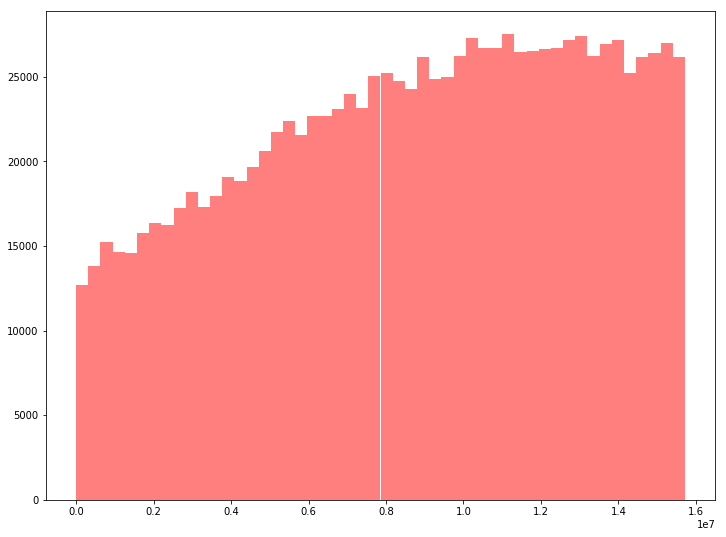

In [47]:
plt.figure()
#plt.hist(train.instanceId_userId.values, 50, color='blue', alpha=0.5, stacked=True)
plt.hist(test.instanceId_userId.values, 50, color='red', alpha=0.5, stacked=True)
plt.show()

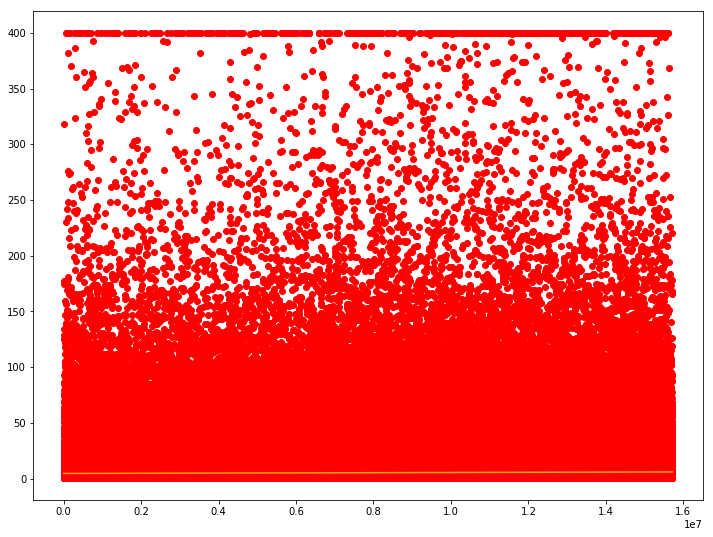

In [65]:
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
stat = train.groupby('instanceId_userId').agg({'objectId': 'count'}).reset_index()
stat['objectId'].clip(upper=400, inplace=True)
x = stat.instanceId_userId.values
y = stat.objectId.values
plt.plot(stat.instanceId_userId.values, stat.objectId.values, marker='o', color='r', ls='')
a, b = np.polyfit(x, y, deg=1)
f = lambda x: a*x + b
plt.plot([min(x), max(x)],[f(min(x)), f(max(x))], c="orange", label="---")
plt.show()

In [66]:
[min(x), max(x)],[f(min(x)), f(max(x))]

([1, 15716692], [4.675623173024054, 6.05310121218764])

In [87]:
train_texts_features.embedding

0          [-0.10615078, -0.010773562, -0.56575644, -0.12...
1          [-0.0683545, 0.07140685, -0.20106804, 0.104985...
2          [-0.02723738, 0.06277889, -0.43565413, 0.18430...
3          [0.045580994, 0.040244624, -0.6059874, 0.25647...
4          [0.0032542336, 0.014345958, 0.0068508917, 0.00...
5          [-0.08434731, 0.44924405, -0.11457637, 0.18142...
6          [0.054944713, -0.016345793, -0.20541555, 0.053...
7          [0.058710147, -0.04227986, -0.21007676, 0.0421...
8          [-0.007924212, 0.023569267, -0.40307418, 0.166...
9          [0.0017259811, -0.04990819, -0.4736356, 0.1148...
10         [-0.09405366, 0.13276497, -0.51096237, 0.12392...
11         [0.07896449, -0.015920404, -0.2127133, 0.10028...
12         [-0.72267175, 0.2736861, -0.6084051, -0.400014...
13         [-0.037868008, 0.30197683, -0.45972252, 0.3364...
14         [0.0309244, 0.04448738, -0.21612203, 0.0947049...
15         [-0.019892128, 0.058245588, -0.3105936, 0.0849...
16         [0.0032542336

In [103]:
kclusterer = KMeansClusterer(3, distance=nltk.cluster.util.cosine_distance, repeats=50)
assigned_clusters3_50 = kclusterer.cluster(
    np.concatenate((train_texts_features.embedding, test_texts_features.embedding)), assign_clusters=True)

In [75]:
kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters6_25 = kclusterer.cluster(
    np.concatenate((train_texts_features.embedding, test_texts_features.embedding)), assign_clusters=True)

In [6]:
kclusterer = KMeansClusterer(4, distance=nltk.cluster.util.cosine_distance, repeats=10)
assigned_clusters4_10 = kclusterer.cluster(
    np.concatenate((train_texts_features.embedding, test_texts_features.embedding)), assign_clusters=True)

/usr/local/lib/python3.7/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))
/usr/local/lib/python3.7/site-packages/nltk/cluster/util.py:133: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))
Error: no centroid defined for empty cluster.
Try setting argument 'avoid_empty_clusters' to True


AssertionError: 

In [76]:
train_texts_features['assigned_clusters'] = assigned_clusters6_25[0:train_texts_features.shape[0]]

In [124]:
pd.DataFrame({'assigned_clusters3_50': assigned_clusters3_50}).to_pickle(output_path + '/assigned_clusters3_50')

In [7]:
train_data.head(200)

,instanceId_userId,instanceId_objectType,objectId,audit_clientType,audit_timestamp,metadata_ownerId,metadata_createdAt,date,liked,clicked,...,ok_groups_count,is_adv,is_recipe,hashes_count,quotes_count,mdots_count,brackets_balance,has_phone,is_poll,e_count
0,1618,0,25814780,0,1517458217938,81088,1517454825000,2018-02-01,0,1,...,0,0,0,0,0,0,0,0,False,1
1,2122,0,10027037,1,1517488844356,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
1070,405739,0,10027037,2,1517511247948,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
1759,659725,0,10027037,0,1517466559543,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
4836,1748401,0,10027037,1,1517511622831,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
6826,2404081,0,10027037,1,1517487632489,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
8062,2796664,0,10027037,0,1517452044806,4016,1517423778000,2018-02-01,0,1,...,0,0,1,0,0,0,9,0,False,1
12652,4257952,0,10027037,1,1517433315078,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
18474,6000712,0,10027037,2,1517459635654,4016,1517423778000,2018-02-01,1,0,...,0,0,1,0,0,0,9,0,False,1
19276,6265702,0,10027037,1,1517509974847,4016,1517423778000,2018-02-01,0,1,...,0,0,1,0,0,0,9,0,False,1


In [18]:
stat = train_data[['metadata_ownerId', 'objectId']].groupby('metadata_ownerId').agg({'objectId': 'count'})
stat.rename(columns={'objectId': 'owner_count'}, inplace=True)

In [25]:
train_data = train_data.join(stat, how='left', on='metadata_ownerId')

In [24]:
train_data.shape

(21620659, 34)

In [18]:
test = create_features(test_data)

In [19]:
del test_data
del train_data
del train_texts_features
del test_texts_features
#del sub
gc.collect()

NameError: name 'sub' is not defined

In [20]:
gc.collect()

125

In [21]:
%%time
seed_everything(341)
model3 = MeanModel([KerasModel({
    'epochs': 30,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5])

model3.fit(train)
pred3 = model3.predict(test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 170)               17850     
_________________________________________________________________
batch_normalization_1 (Batch (None, 170)               680       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 170)               29070     
_________________________________________________________________
batch_normalization_2

In [22]:
model3.coefs = [0.5, 0.5]
pred3 = model3.predict(test)

In [27]:
predT = pd.read_pickle(output_path + '/pred').T1.values

In [29]:
submitA3 = predict_to_submit(test, pred3 + predT * 0.2)
submitA3.to_csv(output_path + "/textSubmitA3.csv.gz", header=False, compression='gzip')

In [ ]:
%%time
seed_everything(341)

modelT = KerasModel({
    'epochs': 30,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'n3': 85,
    'dropout': 0.15,
    'emb': 'embedding',
})
modelT.fit(train)

In [132]:
predT

array([0.12653881, 0.11429563, 0.17078048, ..., 0.05660952, 0.1017186 ,
       0.16263291], dtype=float32)

In [136]:
submitA1 = predict_to_submit(test, pred2 + predT * 0.2)
submitA1.to_csv(output_path + "/textSubmitA2.csv.gz", header=False, compression='gzip')

In [137]:
pd.DataFrame({'T1': predT, 'pred2': pred2, 'pred': pred}).to_pickle(output_path + '/pred')

In [21]:
%%time
seed_everything(341)
'''
KerasModel({
    'epochs': 30,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'n3': 85,
    'dropout': 0.15,
    'emb': 'embedding',
}), 
'''
model = MeanModel([KerasModel({
    'epochs': 30,
    'verbose': 2,
    'n1': 170,
    'n2': 170,
    'dropout': 0.1,
    'emb': 'embedding_keras',
}), LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 25,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})], [0.5, 0.5])

model.fit(train)
pred = model.predict(test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 170)               18190     
_________________________________________________________________
batch_normalization_1 (Batch (None, 170)               680       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 170)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 170)               29070     
_________________________________________________________________
batch_normalization_2

In [22]:
submit = predict_to_submit(test, pred)
submit.to_csv(output_path + "/textSubmit1.csv.gz", header=False, compression='gzip')

In [116]:
lens_stat = defaultdict(int)
for r in submit:
    lens_stat[len(r)] += 1
lens_stat = pd.DataFrame([(k, v) for k, v in lens_stat.items()], columns=['len', 'count'])
lens_stat['relative_count'] = lens_stat['count'] / lens_stat['count'].sum()
lens_stat.head()

,len,count,relative_count
0,2,66422,0.318806
1,3,43664,0.209574
2,4,27742,0.133154
3,8,6431,0.030867
4,16,913,0.004382


In [146]:
lang_stat = pd.concat((train_data, test_data), sort=False)[['lang', 'instanceId_userId']].head(200000) \
    .groupby('lang').count().reset_index().sort_values(['instanceId_userId']).reset_index()
lang_stat.rename(columns={'index': 'lang_index'}, inplace=True)
lang_stat

,lang_index,lang,instanceId_userId
0,16,uz,1
1,13,sr,2
2,7,it,2
3,5,fr,14
4,4,et,15
5,6,hy,15
6,11,ro,24
7,8,ky,35
8,15,uk,43
9,10,ms,45


In [ ]:
'''audit_timestamp = train_data.audit_timestamp.apply(lambda x: int(x) // 1000)
plt.figure(figsize=(35,15))
plt.hist(audit_timestamp, 1800, color='red', alpha=0.5, stacked=True)
plt.show()'''

In [ ]:
'''plt.figure(figsize=(35,15))
plt.hist(audit_timestamp[(audit_timestamp % (3600*24) > 7*3600) & (audit_timestamp % (3600*24) < 20*3600)], 1800, color='red', alpha=0.5, stacked=True)
plt.show()'''

In [ ]:
def is_day(ts):
    ts = int(ts) // 1000
    x = ts % 3600*24
    return x > 7*3600 and x < 20*3600

train_data['is_day'] = train_data.metadata_createdAt.apply(is_day)
test_data['is_day'] = test_data.metadata_createdAt.apply(is_day)